In [2]:
from OpInf import *
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import json
import stiefel

import importlib
importlib.reload(stiefel)

from scipy.io import loadmat
from operators import ckron, ckron_indices

import scienceplots
plt.style.use(["science", "no-latex", "grid"])

check syl solve
True
here
True
6.644630333967357e-14
Use algebraic Stiefel log, metric alpha =  -0.0
dist 3.7699111843077584
NORM TEST1: 0.0
NORM TEST2: 4.21457817647089e-13
NORM TEST3: 7.07788862241987e-15


In [3]:
import numpy as np

def ddt(X, dt, scheme):
    """
    Uses specified difference scheme to approximate dX/dt with uniform time spacing of size dt.
    
    Parameters:
    X (np.array): N-by-K data matrix where each column is the state at one time.
    dt (float): Time step.
    scheme (str): Specifies which scheme is used to approximate time derivative.
    
    Returns:
    tuple: Tuple containing:
        - np.array: N-by-M data matrix of state time derivatives.
        - np.array: M-by-1 vector of indices of state data in X.
    """
    
    N, K = X.shape

    if scheme in [1, 'FE']:  # Forward Euler integration
        dXdt = (X[:, 1:] - X[:, :-1]) / dt
        ind = np.arange(K - 1)
    elif scheme == 'BE':  # Backward Euler integration
        dXdt = (X[:, 1:] - X[:, :-1]) / dt
        ind = np.arange(1, K)
    elif scheme in [2, '2c']:  # 2nd order central differencing
        dXdt = (X[:, 2:] - X[:, :-2]) / (2 * dt)
        ind = np.arange(1, K - 1)
    elif scheme == '2imp':  # 2nd order backward differencing (implicit)
        dXdt = (3 * X[:, 2:] - 4 * X[:, 1:-1] + X[:, :-2]) / (2 * dt)
        ind = np.arange(2, K)
    elif scheme == '2ex':  # 2nd order forward differencing (explicit)
        dXdt = (-3 * X[:, :-2] + 4 * X[:, 1:-1] - X[:, 2:]) / (2 * dt)
        ind = np.arange(K - 2)
    elif scheme in [4, '4c']:  # 4th order central differencing
        dXdt = (X[:, :-4] - 8 * X[:, 1:-3] + 8 * X[:, 3:-1] - X[:, 4:]) / (12 * dt)
        ind = np.arange(2, K - 2)
    elif scheme == '4imp':  # 4th order backward differencing
        dXdt = (25 / 12 * X[:, 4:] - 4 * X[:, 3:-1] + 3 * X[:, 2:-2] - 4 / 3 * X[:, 1:-3] + 1 / 4 * X[:, :-4]) / dt
        ind = np.arange(4, K)
    elif scheme == '4ex':  # 4th order forward differencing
        dXdt = (-25 / 12 * X[:, :-4] + 4 * X[:, 1:-3] - 3 * X[:, 2:-2] + 4 / 3 * X[:, 3:-1] - 1 / 4 * X[:, 4:]) / dt
        ind = np.arange(K - 4)
    else:
        raise ValueError('Specified difference scheme not implemented')

    return dXdt, ind

# Note: Function calls are commented out to adhere to instructions. They should be uncommented for testing purposes.
# Example of function call (commented out):
# X = np.random.rand(10, 5)  # Example


In [4]:
import numpy as np
from scipy.optimize import least_squares


def polynomial_form(x, p):
    """Polynomial representation of the reduced state snapshot data."""
    return [x**degree for degree in range(2, p+1)]



def relative_error(S_exact, S_reconstructed, Sref):
    """Calculate the relative squared Frobenius-norm error."""
    return np.linalg.norm(S_exact - S_reconstructed, 'fro') / np.linalg.norm(S_exact - Sref, 'fro')



def representation_learning_obj(x, snapshot_index, Vr, Vbar, Xi, S, sref, p=2):
    """Objective function for the nonlinear regression problem in the alternating minimization approach."""
    return S[:, snapshot_index] - sref - (Vr @ x) - (Vbar @ Xi @ np.concatenate(polynomial_form(x, p), axis=0))



def alternating_minimization(S, Sref, num_snapshots, max_iter, tol, gamma, r, q, p, initial_Shat=None):
    """
    Performs alternating minimization to solve for Shat given the system parameters.
    
    :param S: The system snapshots.
    :param Sref: The reference state.
    :param num_snapshots: Number of snapshots in S.
    :param max_iter: Maximum number of iterations for the minimization process.
    :param tol: Tolerance for convergence criterion.
    :param initial_Shat: Initial guess for Shat.
    :param gamma: Regularization parameter.
    :param r: Rank for Vr.
    :param q: Rank for Vbar.
    :param p: Order of polynomial form.
    :return: Optimized Shat and the final energy.
    """

    sref = Sref[:, 0]
    nrg_old = 0
    print("***Starting alternating minimizations:")

    # Define additional functions required for optimization here
    # e.g., polynomial_form(x), representation_learning_obj(x), etc.
    
    U, _, _ = np.linalg.svd(S - Sref, full_matrices=False)
    Vr = U[:, :r]
    Vbar = U[:, r:r+q]
    
    # Initialize Shat and other variables
    if initial_Shat:
        Shat = initial_Shat
    
    else:
        Shat = Vr.T @ (S-Sref)          # represent data in POD coordinates
    
    Proj_error = S - Sref - (Vr @ Shat)
    Poly = np.concatenate(polynomial_form(Shat, p=p), axis=0)
    Xi = Vbar.T @ Proj_error @ Poly.T @ np.linalg.inv(Poly @ Poly.T + gamma * np.identity((p - 1)*r))
    
    for niter in range(max_iter):
        # Step 1 - Orthogonal Procrustes (update basis vectors)
        Um, _, Vm = np.linalg.svd((S - Sref) @ np.concatenate([Shat, Xi @ Poly]).T, full_matrices=False)
        Omega = Um @ Vm
        Vr, Vbar = Omega[:, :r], Omega[:, r:r+q]

        # Step 2 - Linear regression (update coefficient matrix)
        Proj_error = S - Sref - (Vr @ Shat)
        rhs = np.linalg.inv(Poly @ Poly.T + (gamma * np.identity((p - 1) * r)))
        Xi = Vbar.T @ Proj_error @ Poly.T @ rhs

        # Step 3 - Nonlinear regression (update reduced state representation)
        for snapshot in range(num_snapshots):
            
            # Shat[:, snapshot] = least_squares(lambda x: representation_learning_obj(x, snapshot, Vr, Vbar, Xi, S, sref, p=p), Shat[:, snapshot], ftol=1e-9).x
            Shat[:, snapshot] = least_squares(representation_learning_obj, Shat[:, snapshot], args=(snapshot, Vr, Vbar, Xi, S, sref, p), ftol=1e-9).x
        Poly = np.concatenate(polynomial_form(Shat, p=p), axis=0)

        # Evaluate convergence criterion
        energy = np.linalg.norm(Vr @ Shat + (Vbar @ Xi @ Poly), 'fro')**2 / np.linalg.norm(S - Sref, 'fro')**2
        diff = abs(energy - nrg_old)
        print(f"\titeration: {niter+1:d}\tsnapshot energy: {energy:e}\t diff: {diff:e}")
        if diff < tol:
            print("***Convergence criterion active!")
            break
        nrg_old = energy  # Update old energy metric

    return Shat, energy, Xi, Vr, Vbar, Poly

# To call this function, you would need to prepare all the required arguments first.
# For example:
# Shat_optimized, final_energy = alternating_minimization(S, Sref, num_snapshots, max_iter, tol, initial_Shat, gamma, r, q, p)


In [5]:
mus = [1.1, 1.05, 1, 0.95, 0.9]
# Load data
T_end_train = 2
dt= 1e-3
Train_T = int(T_end_train/dt)

X_all_nominal = np.load("../examples/burgers/burgersFEniCSx_u_sol_all_RE100.npy")[:, :Train_T+1, :]
X_all_p1per = np.load("../examples/burgers/burgersFEniCSx_u_sol_all_RE100_p1per.npy")[:, :Train_T+1, :]
X_all_n1per = np.load("../examples/burgers/burgersFEniCSx_u_sol_all_RE100_n1per.npy")[:, :Train_T+1, :]
X_all_p5per = np.load("../examples/burgers/burgersFEniCSx_u_sol_all_RE100_p5per.npy")[:, :Train_T+1, :]
X_all_n5per = np.load("../examples/burgers/burgersFEniCSx_u_sol_all_RE100_n5per.npy")[:, :Train_T+1, :]

In [6]:
p = 2
Mp = len(mus)
dt = 1e-3
T_end = 2

config = {
    "N": 2**7 + 1 + 1,
    "dt": 1e-3,
    "T_end": T_end,
    "mus": list(mus),
    "Mp": Mp,
    "K": T_end / dt,  # T_end / dt
    "DS": 1,
    "params": {
        "modelform": "LQCP",
        "modeltime": "continuous",
        "dt": dt,
        "ddt_order": "BE",
        "p": p, # polynomial order
        "lambda1": 5e-2,
        "lambda2": 5e-2,
        "lambda3": 100,
    },
    "type": "single"
}




In [7]:
X_all_nominal.shape

(5, 2001, 130)

In [8]:
X_nominal = np.concatenate([X for X in X_all_nominal], axis=0).T
X_p1per = np.concatenate([X for X in X_all_p1per], axis=0).T
X_n1per = np.concatenate([X for X in X_all_n1per], axis=0).T
X_p5per = np.concatenate([X for X in X_all_p5per], axis=0).T
X_n5per = np.concatenate([X for X in X_all_n5per], axis=0).T

In [9]:
X_list = [X_p1per, X_n1per, X_p5per, X_n5per, X_nominal]

X =  (130, 10005)
X_ref =  (130, 1)
S =  [182.61019219 103.96051164  59.44319585  40.44800931  27.79984476]
idx =  11
rel_err_SVD[idx] =  9.034368619942335e-05
X =  (130, 10005)
X_ref =  (130, 1)
S =  [182.25557676 103.5489728   58.99784923  40.05590471  27.55403553]
idx =  11
rel_err_SVD[idx] =  8.006223042311689e-05
X =  (130, 10005)
X_ref =  (130, 1)
S =  [183.27411586 104.73054211  60.28233983  41.19952589  28.27831031]
idx =  12
rel_err_SVD[idx] =  5.4136889048983505e-05
X =  (130, 10005)
X_ref =  (130, 1)
S =  [181.49609979 102.66738996  58.05145524  39.23856595  27.046048  ]
idx =  11
rel_err_SVD[idx] =  6.19938429653466e-05
X =  (130, 10005)
X_ref =  (130, 1)
S =  [182.43487026 103.75706142  59.2227547   40.25333123  27.67754859]
idx =  11
rel_err_SVD[idx] =  8.509540851420194e-05


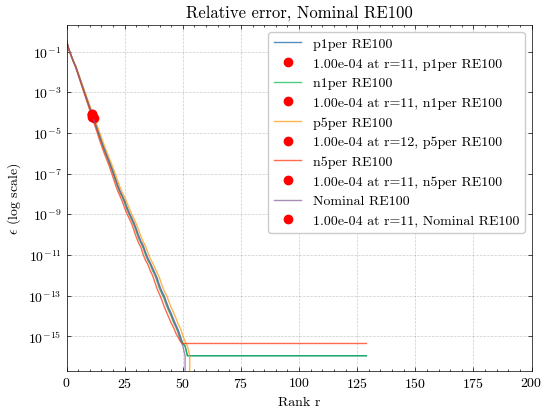

In [10]:
rob_lst = []
rel_err_SVD_lst = []
idx_lst = []
names = [f'p1per RE100', f'n1per RE100', f'p5per RE100', f'n5per RE100', f'Nominal RE100']

fig, ax = plt.subplots(figsize=(6, 4.5))

err_tol = 1e-4

# mus = [0.01] # only one mu for now

for i in range(len(X_list)):
    
    X = X_list[i]
    
    # X_ref is the reference state which is just defined as the mean of the snapshots 
    X_ref = np.mean(X, axis=1)[:, None]
    
    print("X = ", X.shape)
    print("X_ref = ", X_ref.shape)
    
    # svd
    U, S, V = np.linalg.svd((X - X_ref), full_matrices=False)
    print("S = ", S[:5])
    eigvals_SVD = S**2 * (1 / (len(S) - 1))
    # print("eigvals_SVD = \n", eigvals_SVD[:5])
    # append U
    # print("U = ", U.shape)
    rob_lst.append(U)
    
    # calculate the relative error
    rel_err_SVD = 1 - (np.cumsum(eigvals_SVD) / np.sum(eigvals_SVD))
    rel_err_SVD_lst.append(rel_err_SVD)
    # print("rel_err_SVD = \n", rel_err_SVD[:4])

    # print the first idx when it is less than 1e-4
    idx = np.where(rel_err_SVD < err_tol)[0][0]
    idx_lst.append(idx)
    print("idx = ", idx)
    print("rel_err_SVD[idx] = ", rel_err_SVD[idx])
    
    ax.plot(rel_err_SVD_lst[i], label=names[i], linestyle='-', alpha=0.7)
    ax.plot(idx, rel_err_SVD[idx], 'ro', label=f"{err_tol:.2e} at r={idx}, {names[i]}")
    ax.set_yscale('log')
    ax.set_ylabel("$\epsilon$ (log scale)")
    # set limit
    ax.set_xlim([0, 200])
    # ax.set_ylim([1e-13, 1e-3])
    # show grid
    ax.grid(True, alpha=0.2)
    ax.set_xlabel("Rank r")
    ax.set_title("Relative error, Nominal RE100")
    ax.legend()

In [11]:
# Model parameters
r = 11
q_dim = 20
# p = 3

tol = 1e-3      # tolerence for alternating minimization
gamma = 0.1       # regularization parameter
max_iter = 100  # maximum number of iterations

Vr_lst = []
Vbar_lst = []
Shat_lst = []
Xi_lst = []
Poly_lst = []

for i in range(len(X_list)):
    # Procustes problem for each mu
    X = X_list[i]
    num_snapshots = X.shape[1]
    print("num_snapshots: ", num_snapshots)
    print("X = ", X.shape)
    X_ref = np.mean(X, axis=1)[:, None]
    # X_ref = np.zeros((X.shape[0]))[:, None]
    X_centered = X - X_ref

    U, S, Vr = np.linalg.svd(X_centered, full_matrices=False)
    
    Vr = U[:, :r]
    Vbar = U[:, r:r + q_dim]
    q = Vr.T @ X_centered
    Proj_error = X_centered - (Vr @ q)
    Poly = np.concatenate(polynomial_form(q, p), axis=0)
    Xi = Vbar.T @ Proj_error @ Poly.T @ np.linalg.inv(Poly @ Poly.T + gamma * np.identity((p - 1)*r))

    Gamma_MPOD = X_ref + (Vr @ q) + (Vbar @ Xi @ Poly)
    print(f"\nReconstruction error: {relative_error(X, Gamma_MPOD, X_ref):.4%}")
    
    Vr_lst.append(Vr)
    Vbar_lst.append(Vbar)
    Shat_lst.append(q)
    Xi_lst.append(Xi)
    Poly_lst.append(Poly)

    # q, energy, Xi, Vr, Vbar, Poly = alternating_minimization(X, X_ref, num_snapshots, max_iter, 1e-3, gamma, r, q, p, initial_Shat=None)

    # print("q = ", q.shape)
    # print("qbar = ", qbar.shape)

num_snapshots:  10005
X =  (130, 10005)

Reconstruction error: 1.1833%
num_snapshots:  10005
X =  (130, 10005)

Reconstruction error: 1.1202%
num_snapshots:  10005
X =  (130, 10005)

Reconstruction error: 1.3120%
num_snapshots:  10005
X =  (130, 10005)

Reconstruction error: 0.9971%
num_snapshots:  10005
X =  (130, 10005)

Reconstruction error: 1.1517%


In [11]:
Gamma_MPOD = X_ref + (Vr @ q) + (Vbar @ Xi @ Poly)
print(f"\nReconstruction error: {relative_error(X, Gamma_MPOD, X_ref):.4%}")


Reconstruction error: 1.1517%


In [12]:
# Get nominal Reynolds for OpInf
X = X_list[-1][:, ]

In [13]:
Mp = len(mus)
Nsnapshots = X.shape[1]
dShatdt = []
Shat_lst = []
dSdt = []
for j in range(Mp):
    start_ind = int((j) * Nsnapshots/Mp)
    end_ind = int((j+1) * Nsnapshots/Mp)
    print("start_ind: ", start_ind)
    print("end_ind: ", end_ind)
    ddtshat, ind = ddt(q[:, start_ind:end_ind], dt=dt, scheme='BE')
    ddts, ind = ddt(X[:, start_ind:end_ind], dt=dt, scheme="BE")
    dShatdt.append(ddtshat)
    ind = np.array(ind) + int((j) * Nsnapshots/Mp)
    Shat_lst.append(q[:, ind])
    dSdt.append(ddts)
    

start_ind:  0
end_ind:  2001
start_ind:  2001
end_ind:  4002
start_ind:  4002
end_ind:  6003
start_ind:  6003
end_ind:  8004
start_ind:  8004
end_ind:  10005


In [14]:
import importlib
import OpInf
# import reloading
# reload the whole OpInf module
importlib.reload(OpInf)
from OpInf import *


In [15]:
def initial_condition(coord):
    if coord <= 0.5:
        return np.sin(2 * np.pi * coord)
    
    return 0

# update config file with truncation order r
config['robparams'] = {
    "r": int(r)
}

Shat_py = np.concatenate(Shat_lst, axis=1)
dShatdt_py = np.concatenate(dShatdt, axis=1).T
dSdt_py = np.hstack(dSdt)

print("Shape of Shat_py: ", Shat_py.shape)
print("Shape of dShatdt_py: ", dShatdt_py.shape)
# [operators] = inferOperators_NL(Shat, U, params, dShatdt);

operators = infer_operators_nl(Shat_py, None, config['params'], dShatdt_py)
# operators = infer_operators_nl(q, None, config['params'], /dShatdt_py)

Shape of Shat_py:  (11, 10000)
Shape of dShatdt_py:  (10000, 11)
Generating ghat ...
drp:  187
Obtained data matrix...
Regularization parameters:  0.05 0.05 100
Solving...
Solved!


In [16]:
config['robparams'] = {
    "r": int(r)
}

N = int(config['N'])
dt = config['dt']
T_end = config['T_end']
mus = config['mus']  # Assuming mus is saved as a string that represents a Python expression
Mp = config['Mp']
K = int(config['K'])
DS = config['DS']
params = config['params']  # This will be a dictionary in Python
robparams = config['robparams']  # This will be a dictionary in Python


coord = np.linspace(0, 1, N)
print("coord = ", coord.shape)
IC = np.array([initial_condition(c) for c in coord])
q0 = Vr.T @ (IC[:, None] - X_ref).flatten()
time_domain = np.arange(0, T_end, dt)
train_size = Shat_py.shape[1]

# regs = [1e1, 3e3, 1e9]
# regs = [0.001, 20, 1e5]
Shat_true = Shat_lst[2]
regs_product = [1e-3, 1e-3, 1, 1e1, 1e4, 5, 1e3, 1e7, 5]
# regs_product = [1e-3, 1e-3, 1, 23, 60, 10]
# regs_product = [1e-3, 1e-2, 5, 1e-3, 1e-2, 5, 1e-3, 1e-1, 5]
# regs, operators = train_minimize(Shat_py, dShatdt_py, Shat_true, train_size, r, regs, time_domain, q0, params, testsize=None, margin=1.1)
regs, errors = train_gridsearch(Shat_py, dShatdt_py, Shat_true, train_size, r, regs_product, time_domain, q0, params, testsize=None, margin=1.1)


coord =  (130,)
Constructing least-squares solver, r=11
TRAINING 25 ROMS
(1/25) Testing ROM with (0.001, 10.0, 1000.0)
Generating ghat ...
drp:  187
Obtained data matrix...
Regularization parameters:  0.001 10.0 1000.0
Solving...
Solved!
Integrating...
Bound check passed
(2/25) Testing ROM with (0.001, 10.0, 10000.0)
Generating ghat ...
drp:  187
Obtained data matrix...
Regularization parameters:  0.001 10.0 10000.0
Solving...
Solved!
Integrating...
Bound check passed
(3/25) Testing ROM with (0.001, 10.0, 100000.0)
Generating ghat ...
drp:  187
Obtained data matrix...
Regularization parameters:  0.001 10.0 100000.0
Solving...
Solved!
Integrating...
Bound check passed
(4/25) Testing ROM with (0.001, 10.0, 1000000.0)
Generating ghat ...
drp:  187
Obtained data matrix...
Regularization parameters:  0.001 10.0 1000000.0
Solving...
Solved!
Integrating...
Bound check passed
(5/25) Testing ROM with (0.001, 10.0, 10000000.0)
Generating ghat ...
drp:  187
Obtained data matrix...
Regularization 

In [17]:
print("Errors:, ", errors)
print("regs: ", regs)

Errors:,  0.011074908512963931
regs:  [0.001, 10.0, 10000000.0]


In [18]:
# regs = [0.0005399173326341194, 23.61197176062329, 202651972.5062846]

params['lambda1'] = regs[0]
params['lambda2'] = regs[1]
if len(regs) > 2:
    params['lambda3'] = regs[2]

# params['lambda1'] = (5e-2)**2
# params['lambda2'] = (5e-2)**2
# if len(regs) > 2:
#     params['lambda3'] = regs[2]
operators = infer_operators_nl(Shat_py, None, config['params'], dShatdt_py)

Generating ghat ...
drp:  187
Obtained data matrix...
Regularization parameters:  0.001 10.0 10000000.0
Solving...
Solved!


In [127]:
from stiefel import *
import importlib
importlib.reload(stiefel)
N_stiefel_samples = 1000

stiefel_samples_Vr = stiefel.gen_stiefel_samples(N_stiefel_samples, Vr_lst, tau=0.00001, metric_alpha=0.0000000000000)
stiefel_samples_Vbar = stiefel.gen_stiefel_samples(N_stiefel_samples, Vbar_lst, tau=0.00001, metric_alpha=0.000000000000)

Use algebraic Stiefel log, metric alpha =  0.0
Use algebraic Stiefel log, metric alpha =  0.0
Use algebraic Stiefel log, metric alpha =  0.0
Use algebraic Stiefel log, metric alpha =  0.0
Use algebraic Stiefel log, metric alpha =  0.0
                                     CVXPY                                     
                                     v1.4.2                                    
(CVXPY) Apr 23 01:34:55 PM: Your problem has 4 variables, 3 constraints, and 0 parameters.
(CVXPY) Apr 23 01:34:55 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 23 01:34:55 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Apr 23 01:34:55 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Apr 23 01:34:55 PM: Your problem is compiled with the CPP canonicalization backend.
------------------------------------------------------------------------------

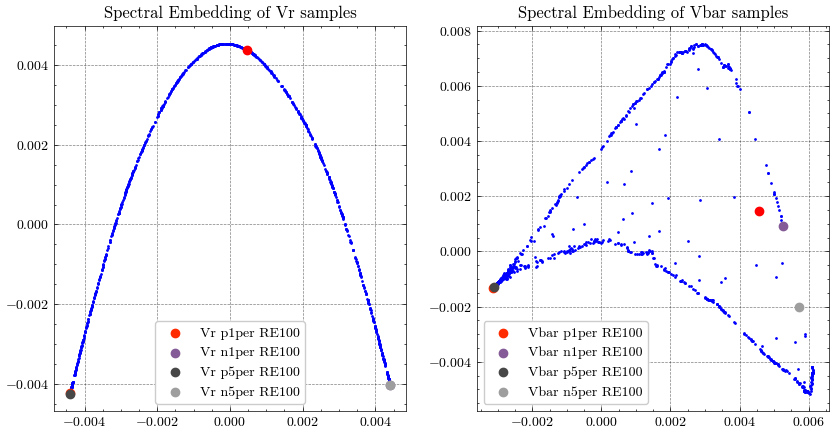

In [194]:
# plot spectral embedding of the generated stiefel sampels
flat_Vr_arr = np.concatenate([rob.flatten()[:, None] for rob in Vr_lst], axis=1)
flat_Vbar_arr = np.concatenate([rob.flatten()[:, None] for rob in Vbar_lst], axis=1)
rob_Vr_all = np.concatenate([rob.flatten()[:, None] for rob in stiefel_samples_Vr] + [flat_Vr_arr], axis=1)
rob_Vbar_all = np.concatenate([rob.flatten()[:, None] for rob in stiefel_samples_Vbar] + [flat_Vbar_arr], axis=1)

from sklearn.manifold import SpectralEmbedding
import matplotlib.pyplot as plt

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Perform spectral embedding
embedder = SpectralEmbedding(n_components=2)
embedding_Vr = embedder.fit_transform(rob_Vr_all.T)
embedding_Vbar = embedder.fit_transform(rob_Vbar_all.T)

# Plot the embeddings
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(embedding_Vr[:-1, 0], embedding_Vr[:-1, 1], color='blue', s=1)
plt.scatter(embedding_Vr[-1, 0], embedding_Vr[-1, 1], color='red')

for i in range(len(Vr_lst) - 1):
    plt.scatter(embedding_Vr[-i-2, 0], embedding_Vr[-i-2, 1], color=colors[i+3], label=f"Vr {names[i]}")

plt.legend()
plt.title('Spectral Embedding of Vr samples')


plt.subplot(1, 2, 2)
plt.scatter(embedding_Vbar[:-1, 0], embedding_Vbar[:-1, 1], color='blue', s=1)
plt.scatter(embedding_Vbar[-1, 0], embedding_Vbar[-1, 1], color='red')

for i in range(len(Vbar_lst) - 1):
    plt.scatter(embedding_Vbar[-i-2, 0], embedding_Vbar[-i-2, 1], color=colors[i+3], label=f"Vbar {names[i]}")

plt.legend()
plt.title('Spectral Embedding of Vbar samples')

plt.show()

In [141]:
modelform = config['params']['modelform']

def rhs(t, state, operators, multi_indices, modelform, input_func=None):
    r"""Evaluate the right-hand side of the model by applying each operator
    and summing the results.

    This is the function :math:`\Ophat(\qhat, \u)`
    where the model can be written as one of the following:

    * :math:`\ddt\qhat(t) = \Ophat(\qhat(t), \u(t))` (continuous time)
    * :math:`\qhat_{j+1} = \Ophat(\qhat_j, \u_j)` (discrete time)
    * :math:`\widehat{\mathbf{g}} = \Ophat(\qhat, \u)` (steady state)

    Parameters
    ----------
    state : (r,) ndarray
        State vector.
    input_ : (m,) ndarray or None
        Input vector corresponding to the state.

    Returns
    -------
    evaluation : (r,) ndarray
        Evaluation of the right-hand side of the model.
    """
    state = np.atleast_1d(state)
    
    # print("State shape: ", state.shape)
    
    out = np.zeros(state.shape, dtype=float)
    # gs = gen_poly(state[:, None], p=2)  # Assuming gen_poly is designed for column vector input
    
    # print("Solving for regularization parameters: ", params['lambda1'], params['lambda2'], params['lambda3'])
    
    if 'L' in modelform:
        # print("adding A")
        out += operators['A'] @ state
    
    if 'Q' in modelform:
        # ssq = get_x_sq(state[:, None].T).T  # Assuming get_x_sq can handle the shape
        # out += operators['F'] @ ssq.flatten()
        # print("adding F")
        mask = ckron_indices(state.shape[0])
        out += (operators["F"] @ np.prod(state[mask], axis=1))
        
    if 'P' in modelform:
        gs = gen_poly(state[:, None], p=p, multi_indices=multi_indices)  # Assuming gen_poly is designed for column vector input
        out += (operators['P'] @ gs).flatten()
        
    if 'C' in modelform:
        out += operators['C'].flatten()
    
    return out


In [138]:
X_all_nominal_full = np.load("../examples/burgers/burgersFEniCSx_u_sol_all_RE100.npy")

In [139]:
X_all_nominal_full.shape

(5, 8000, 130)

In [146]:
import tqdm

N_samples = 1000
abs_error_full_lst = []
relative_error_window_lst = []
s_rec_full_lst = []

for i in tqdm.tqdm(range(N_samples)):
    # randomly choose 1 from stiefel_samples_Vr and 1 from stiefel_samples_Vbar
    idx_Vr = np.random.randint(0, N_stiefel_samples)
    idx_Vbar = np.random.randint(0, N_stiefel_samples)
    Vr_sample = stiefel_samples_Vr[idx_Vr]
    Vbar_sample = stiefel_samples_Vbar[idx_Vbar]
    

    coord = np.linspace(0, 1, N)
    # print("coord = ", coord.shape)
    IC = np.array([initial_condition(c) for c in coord])
    q0 = Vr_sample.T @ (IC[:, None] - X_ref).flatten()
    
    T_end_full = 8
    time_domain_full = np.arange(0, T_end_full, dt)
    
    train_size = Shat_py.shape[1]

    multi_indices = generate_multi_indices_efficient(len(q0), p=p)
    

    modelform = config['params']['modelform']
    out_full = scipy.integrate.solve_ivp(
                rhs,  # Integrate this function
                [time_domain_full[0], time_domain_full[-1]],  # over this time interval
                q0,  # from this initial condition
                t_eval=time_domain_full,  # evaluated at these points
                args=[operators, multi_indices, modelform, None],  # additional arguments to rhs
                
            )
    
    s_hat_full = out_full.y
    poly_full = np.concatenate(polynomial_form(s_hat_full, p=p), axis=0)
    Xi = Xi_lst[-1] # the nominal Xi
    # print("Poly shape: ", poly_full.shape)

    s_rec_full = X_ref + Vr_sample @ s_hat_full + Vbar_sample @ Xi @ poly_full
    
    
    abs_error_full = np.abs(X_all_nominal_full[2].T - s_rec_full)
    relative_error_window = np.linalg.norm(X_all_nominal_full[2].T[:, T_end:] - s_rec_full[:, T_end:], 'fro') / np.linalg.norm(X_all_nominal_full[2].T[:, T_end:], 'fro')
    
    abs_error_full_lst.append(abs_error_full)
    relative_error_window_lst.append(relative_error_window)
    s_rec_full_lst.append(s_rec_full)
    
    

100%|██████████| 1000/1000 [04:35<00:00,  3.64it/s]


In [153]:
# mean relative error across the testing window
mean_relative_error = np.mean(relative_error_window_lst)
std_relative_error = np.std(relative_error_window_lst)
coeff_var = std_relative_error / mean_relative_error
print(f"Mean relative error: {mean_relative_error:.4%}")
print(f"Std relative error: {std_relative_error:.4%}")
print(f"Coefficient of variation: {coeff_var:.4%}")

Mean relative error: 8.5320%
Std relative error: 0.1639%
Coefficient of variation: 1.9208%


In [135]:
X_all_nominal.shape

(5, 2001, 130)

In [172]:
# coefficient of variation of s_rec_full
coeff_var_s_rec_full = np.std(s_rec_full_lst, axis=0) / (np.mean(s_rec_full_lst, axis=0))
std_s_rec_full = np.std(s_rec_full_lst, axis=0)

/tmp/ipykernel_1881387/2287357634.py:2: RuntimeWarning: invalid value encountered in divide
  coeff_var_s_rec_full = np.std(s_rec_full_lst, axis=0) / (np.mean(s_rec_full_lst, axis=0))


In [189]:
#  mean reconstruction
mean_s_rec_full = np.mean(s_rec_full_lst, axis=0).T

In [188]:
# replace NaN with 0
coeff_var_s_rec_full = np.nan_to_num(coeff_var_s_rec_full)

X =  (130, 8000)
Y =  (130, 8000)
s_ref_all[i] =  (8000, 130)


/tmp/ipykernel_1881387/1581724264.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


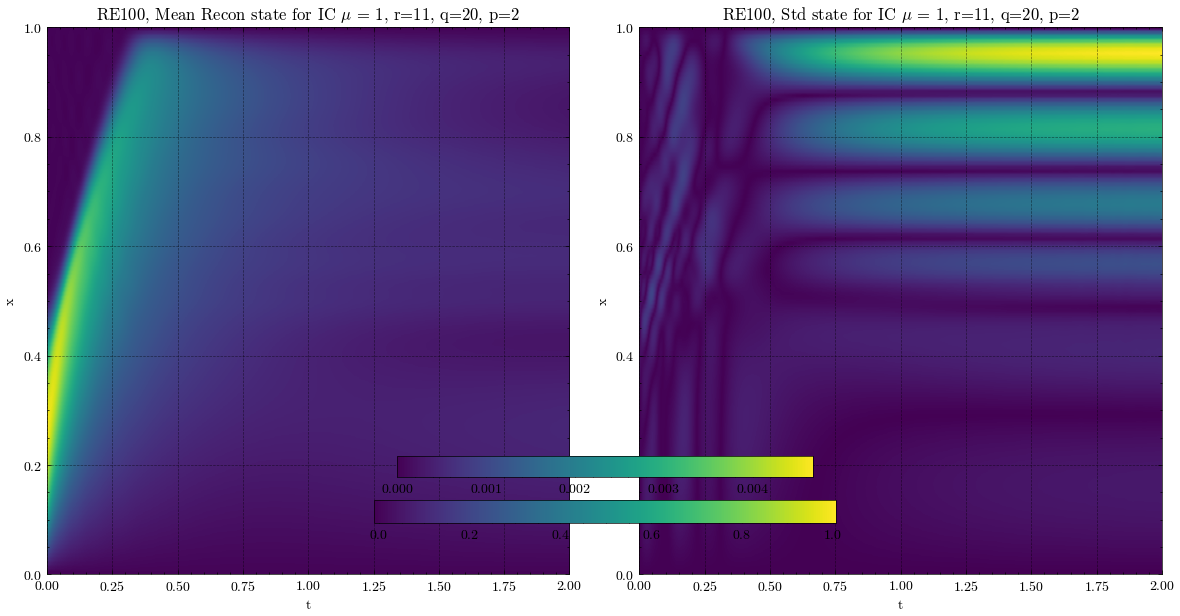

In [191]:
# plot the results side by side
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming s_ref_all is a list of 2D numpy arrays
for i in range(1):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    XX, YY = np.meshgrid(np.linspace(0.0, T_end, int(mean_s_rec_full.shape[0])), np.linspace(0.0, 1.0, mean_s_rec_full.shape[1]))
    print("X = ", XX.shape)
    print("Y = ", YY.shape)
    print("s_ref_all[i] = ", mean_s_rec_full.shape)
    # s = ax.plot_surface(X, Y, s_ref_all[i].reshape(N, int(K+1)), cmap='viridis')
    c1 = axs[0].imshow(mean_s_rec_full.T, extent=[np.min(XX), np.max(XX), np.min(YY), np.max(YY)], origin='lower', aspect='auto')
    # fig.colorbar(c)
    axs[0].set_xlabel('t')
    axs[0].set_ylabel('x')
    axs[0].set_title(f'RE100, Mean Recon state for IC $\mu$ = {mus[2]}, r={r}, q={q_dim}, p={p}')
    
    c2 = axs[1].imshow(std_s_rec_full, extent=[np.min(XX), np.max(XX), np.min(YY), np.max(YY)], origin='lower', aspect='auto')
    # c2 = axs[1].imshow(s_rec_all[i].reshape(N, int(K+1)), extent=[np.min(X), np.max(X), np.min(Y), np.max(Y)], origin='lower', aspect='auto')
    # fig.colorbar(c)
    axs[1].set_xlabel('t')
    axs[1].set_ylabel('x')
    axs[1].set_title(f'RE100, Std state for IC $\mu$ = {mus[2]}, r={r}, q={q_dim}, p={p}')
    
    # use same colorbar for both plots, the range is determined by the maximum and minimum values of the two plots
    # vmin = np.min([np.min(coeff_var_s_rec_full[2]), np.min(coeff_var_s_rec_full)])
    # vmax = np.max([np.max(std_s_rec_full[2]), np.max(std_s_rec_full)])
    # c1.set_clim(vmin=vmin, vmax=vmax)
    # c2.set_clim(vmin=vmin, vmax=vmax)
    
    fig.colorbar(c1, ax=axs, orientation='horizontal', fraction=0.05, pad=0.05)
    fig.colorbar(c2, ax=axs, orientation='horizontal', fraction=0.05, pad=0.05)
    plt.tight_layout()
    
    
    plt.show()